# Model annealing
Infer a cosmological model via Continuous Tempering Langevin. 

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# numpyro.set_platform("gpu")
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.60' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import random, jit, vmap, grad

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Continuous Tempering Langevin")
from montecosmo.utils import pickle_dump
save_directory = os.path.expanduser("~/scratch/pickles/")

feynmangpu04.cluster.local


gpu [cuda(id=0)]


2024-01-17 14:34:20.597268: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Import and simulate fiducial

In [13]:
from montecosmo.models import pmrsd_model, prior_model, model_config, get_logp_and_score_fn, get_simulator

# Build model
model_config['scale_factor_lpt'] = 0.5
model_config['mesh_size'] = 64*np.ones(3, dtype=int)
print(f"{model_config=}")
model = partial(pmrsd_model, **model_config)

# Get latent variables and fix cosmological parameters
cosmo_names = ['Omega_c', 'sigma8']
cosmo_labels = [r'\Omega_c', r'\sigma_8']

# Get fiducial parameters
cond_params = {cosmo_name+'_base':0. for cosmo_name in cosmo_names}
fiduc_simulator = get_simulator(condition(model, cond_params))
fiduc_params = fiduc_simulator(rng_seed=0)
fiduc_cosmo_params = {name: fiduc_params[name] for name in cosmo_names}

# Condition model on observables
obs_params = {name: fiduc_params[name] for name in ['obs_mesh','Omega_c_base','sigma8_base','b1_base','b2_base','bs_base','bnl_base']}
observed_model = condition(model, obs_params)
logp_fn, score_fn = get_logp_and_score_fn(observed_model)

model_config={'mesh_size': array([64, 64, 64]), 'box_size': array([640, 640, 640]), 'scale_factor_lpt': 0.5, 'scale_factor_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': False}


## Init diffusion

In [3]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, ReversibleHeun
from jax.tree_util import tree_map
from jax import eval_shape

def get_run_langevin(t0, t1, dt0, ts, score_fn, noise_fn, sample_shape_struct):
    drift = lambda t, y, args: tree_map(lambda x: -x/2, score_fn(y, model_kwargs={'noise':noise_fn(t)}))
    diffusion = lambda t, y, args: tree_map(lambda x: jnp.ones_like(x), y)
    solver = Euler()
    saveat = SaveAt(ts=ts)

    @jit
    @vmap
    def run_langevin(y, seed):
        brownian_motion = VirtualBrownianTree(t0, t1, tol=jnp.abs(dt0)/10, shape=sample_shape_struct, key=seed)
        terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
        return diffeqsolve(terms, solver, t0, t1, dt0=dt0, y0=y, max_steps=10_000, saveat=saveat).ys
    
    return run_langevin

init_simulator = jit(vmap(get_simulator(partial(prior_model, model_config['mesh_size']))))
logp_vfn, score_vfn = jit(vmap(logp_fn)), jit(vmap(score_fn))

sample_key, diffeq_key = random.split(random.PRNGKey(43), 2)
n_samples = 3
init_params = init_simulator(random.split(sample_key, n_samples))
init_params = {'init_mesh_base':init_params['init_mesh_base']}
sample_shape_struct = eval_shape(lambda x: tree_map(lambda y:y[0], x), init_params)
t0, t1, dt0 = 1, 0., -1e-4
ts = jnp.linspace(t0,t1,11)

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/diffrax/adjoint.py:665: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  _loop_backsolve.defvjp(_loop_backsolve_fwd, _loop_backsolve_bwd)


In [4]:
from jax.flatten_util import ravel_pytree
scores = score_vfn(init_params, {'noise':jnp.ones(n_samples)})
score_flat = ravel_pytree(scores)[0]
jnp.min(score_flat)*dt0, jnp.max(score_flat)*dt0 # check if steps are not too big

(Array(0.00385384, dtype=float32), Array(-0.00193249, dtype=float32))

In [ ]:
noise_fn = lambda t: t/t0
run_langevin = get_run_langevin(t0, t1, dt0, ts, score_fn, noise_fn, sample_shape_struct)
diffus_run = run_langevin(init_params, random.split(diffeq_key, n_samples))
diffus_run

## Power spectrum convergence

In [5]:
mlflow.end_run()
mlflow.start_run(run_name="Pk convergence")
# mlflow.start_run(run_id="")
mlflow.log_params(model_config)
mlflow.log_params({'t0':t0,'t1':t1,'dt0':dt0})

from montecosmo.metrics import power_spectrum
pk_init = power_spectrum(fiduc_params['init_mesh'], kmin=0.001, dk=0.01, box_size=model_config['box_size'])

### $P_0(k)$ to $P_0(k)$

In [22]:
from montecosmo.bricks import get_cosmo_and_init
from itertools import pairwise
noises = jnp.linspace(0,1,9)[::-1]
# noises = jnp.linspace(0,1,10)[::-1]
pks = np.empty((len(noises), n_samples, len(ts), *pk_init[1].shape))
current_params = dict(init_params)

mlflow.log_metric('stop',0)
# for i_noise, noise in enumerate(noises):
for i_noise, (noise0, noise1) in enumerate(pairwise(noises)):
    print(f"noise index {i_noise+1}/{len(noises)}")
    # noise_fn = lambda t: noise
    noise_fn = lambda t: (noise0-noise1)*(t-t1)/(t0-t1) + noise1
    print(f"from {noise_fn(t0)} to {noise_fn(t1)}")
    run_langevin = get_run_langevin(t0, t1, dt0, ts, score_fn, noise_fn, sample_shape_struct)
    key, diffeq_key = random.split(diffeq_key, 2)
    diffus_run = run_langevin(current_params, random.split(key, n_samples))
    current_params = tree_map(lambda x: x[:,-1], diffus_run)
    for i_sample in range(n_samples):
        for i_time in range(len(ts)):
            # cosmo_base = [diffus_run[name+'_base'][i_sample, i_time] for name in cosmo_names]
            cosmo_base = [fiduc_params[name+'_base'] for name in cosmo_names]
            init_base = diffus_run['init_mesh_base'][i_sample, i_time]
            _, init_mesh = get_cosmo_and_init(cosmo_base, init_base, model_config['mesh_size'], model_config['box_size'])
            _, pks[i_noise, i_sample, i_time] = power_spectrum(init_mesh, kmin=0.001, dk=0.01, box_size=model_config['box_size'])
mlflow.log_metric('stop',1)
mlflow.log_metric('stop',0)

noise index 1/9
from 1.0 to 0.875
noise index 2/9
from 0.875 to 0.75
noise index 3/9
from 0.75 to 0.625
noise index 4/9
from 0.625 to 0.5
noise index 5/9
from 0.5 to 0.375
noise index 6/9
from 0.375 to 0.25
noise index 7/9
from 0.25 to 0.125
noise index 8/9
from 0.125 to 0.0


(None, None)

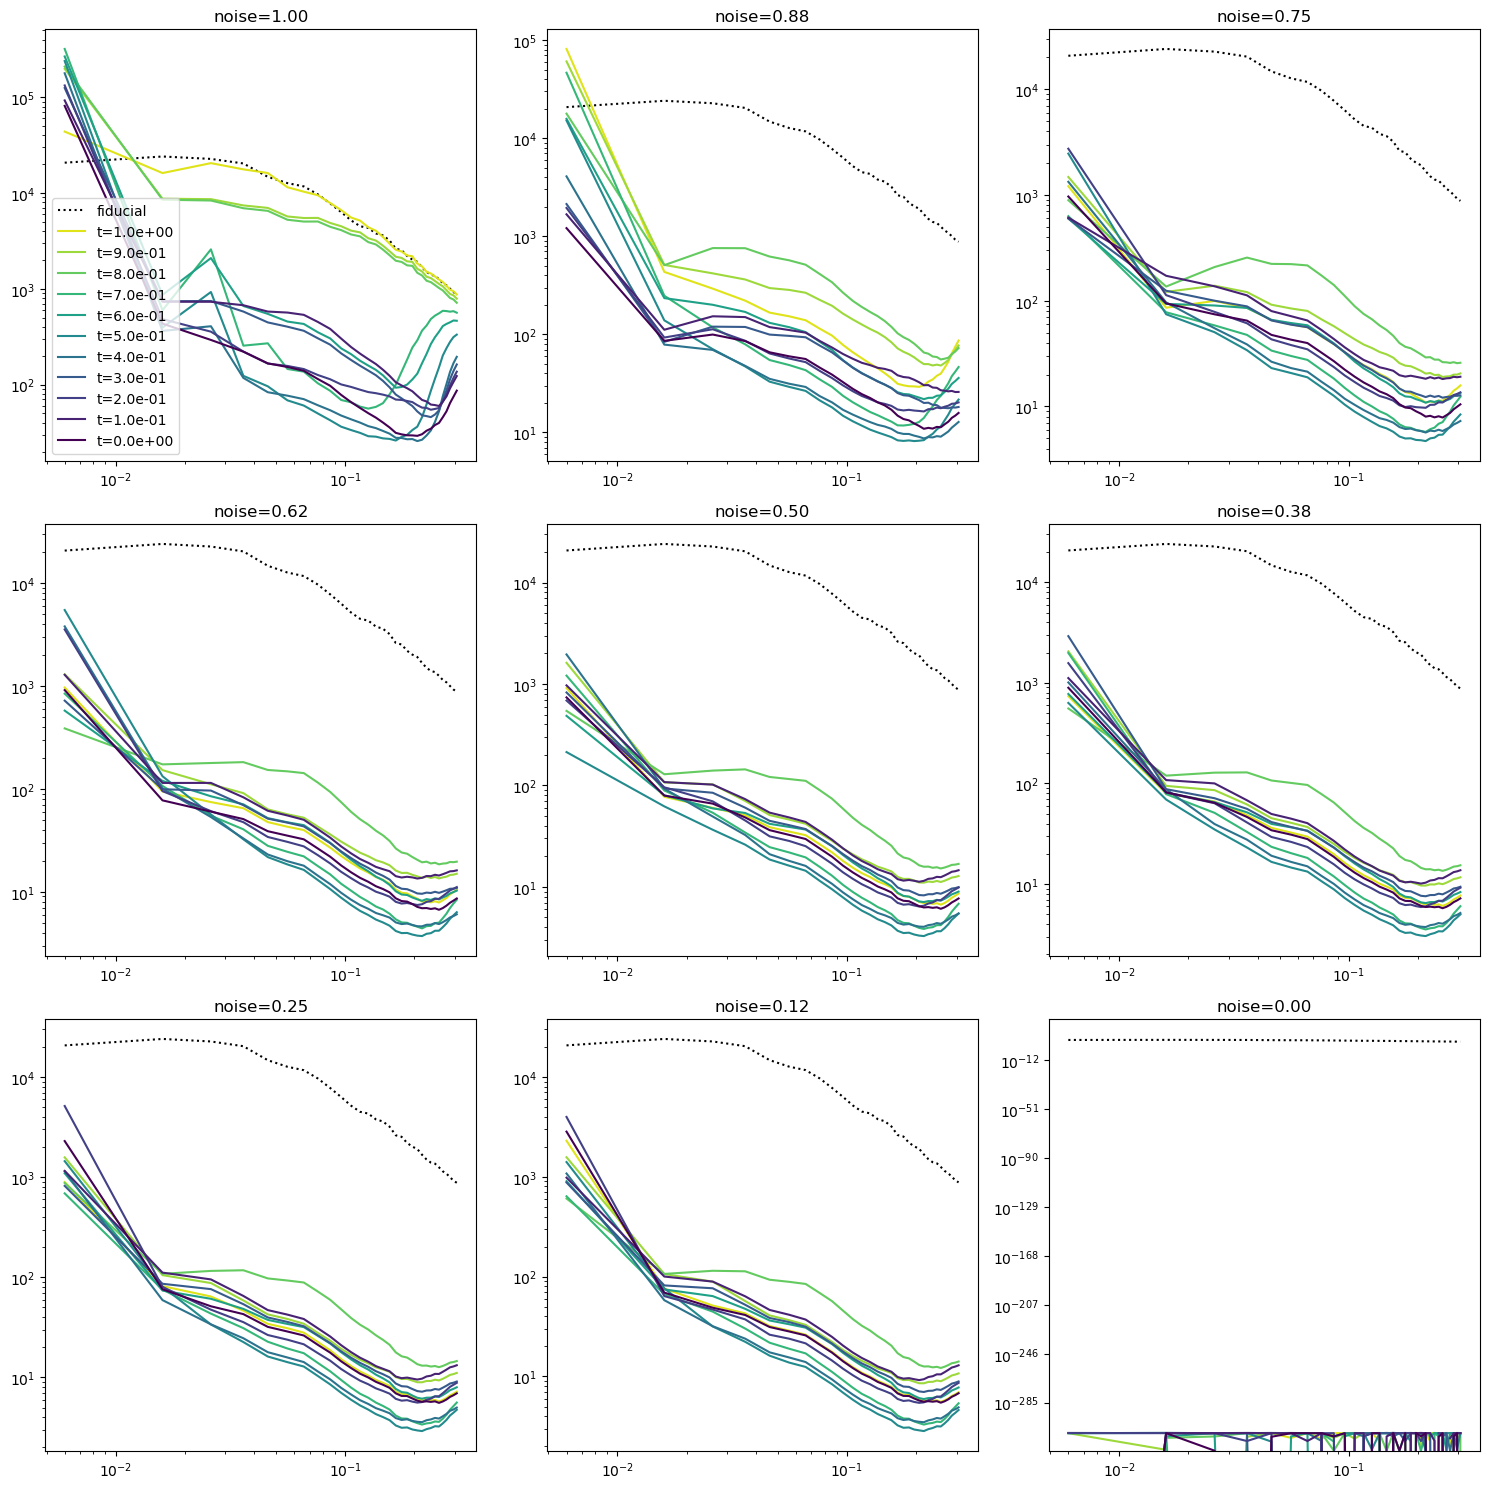

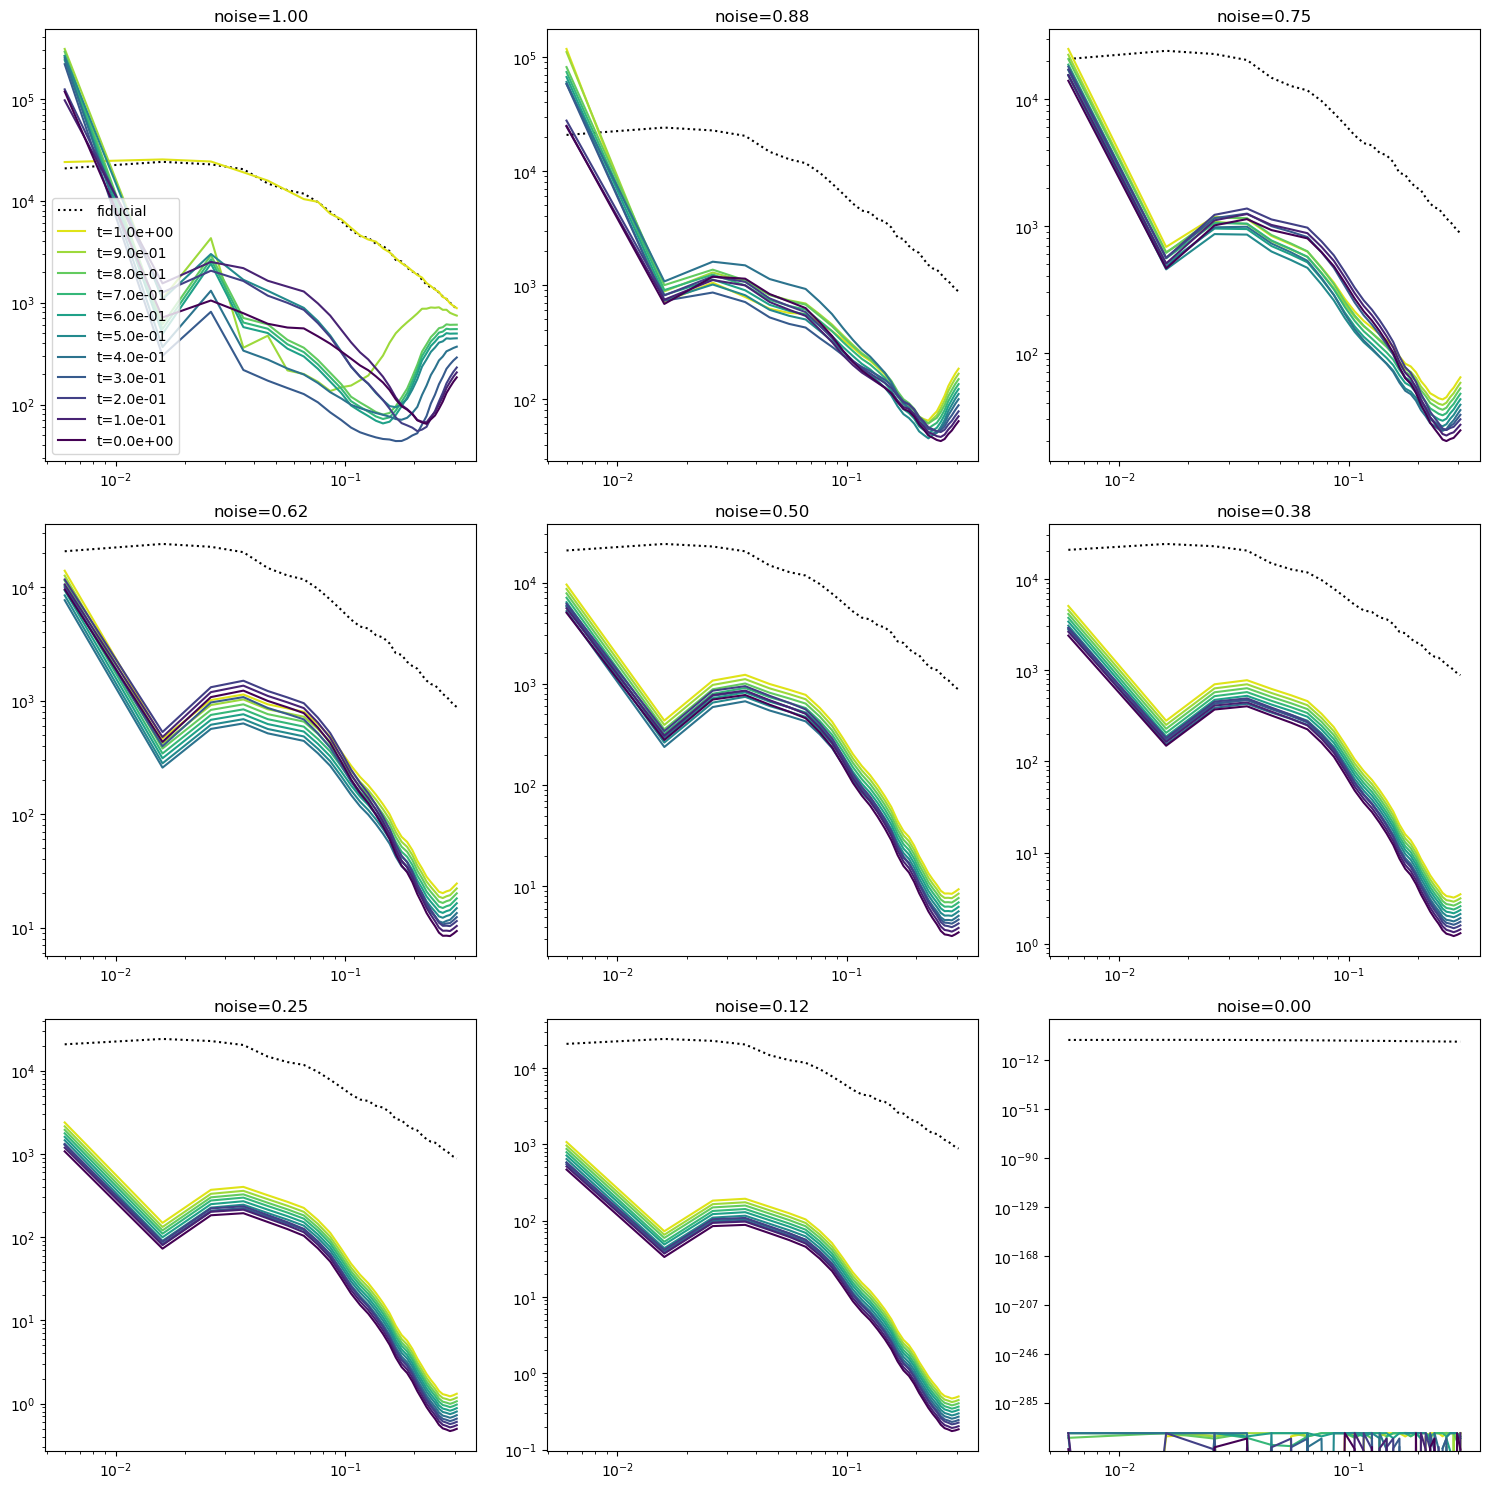

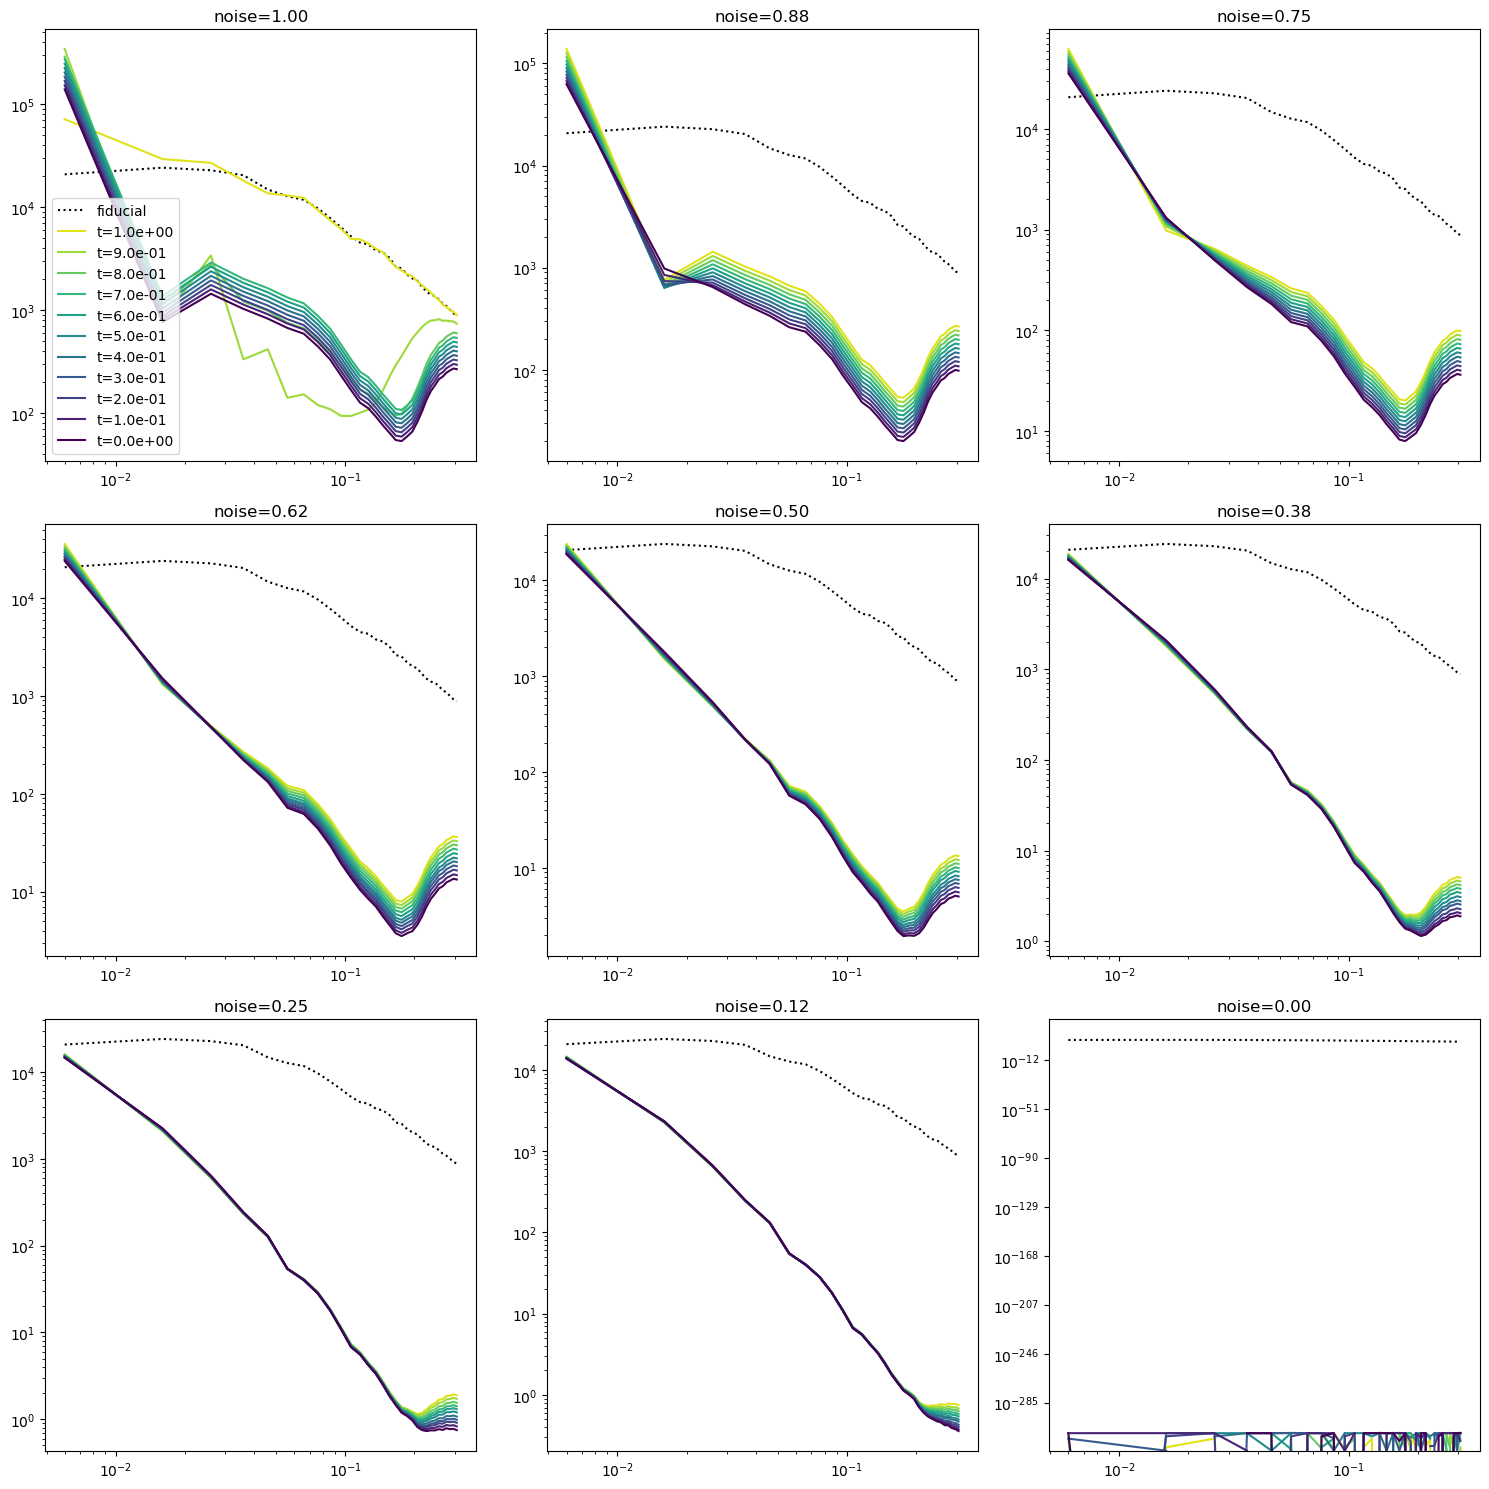

In [23]:
# plot_fn = lambda pk, *args, **kwargs: plt.plot(pk_init[0], pk_init[0]*pk, *args, **kwargs)
plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk_init[0], pk, *args, **kwargs)

for i_sample in range(n_samples):
    plt.figure(figsize=(15,15))
    for i_noise, noise in enumerate(noises):
        plt.subplot(int(np.ceil(len(noises)/3)), 3, i_noise+1)
        colors = plt.get_cmap('viridis')(np.linspace(0,.95,len(ts)))[::-1]
        plt.gca().set_prop_cycle(color=colors)
        plot_fn(pk_init[1][0], 'k:', label="fiducial")
        for i_time, time in enumerate(ts):
            plot_fn(pks[i_noise, i_sample, i_time, 0, :], label=f"t={time:.1e}")
        if i_noise==0:plt.legend()
        plt.title(f"noise={noise:.2f}")
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), f"pk0_to_pk0_lin_{i_sample}.svg")
    plt.show()

### $P_0(k)$ to $P_1(k)$

In [24]:
# Recondition model on new observable
cond_params2 = dict(cond_params)
cond_params2['sigma8_base'] = -2.
fiduc_params2 = get_simulator(condition(model, cond_params2))(rng_seed=0)
obs_params2 = dict(obs_params)
obs_params['obs_mesh'] = fiduc_params2['obs_mesh']
logp_fn2, score_fn2 = get_logp_and_score_fn(condition(model, obs_params2))
pk_init2 = power_spectrum(fiduc_params2['init_mesh'], kmin=0.001, dk=0.01, box_size=model_config['box_size'])

In [25]:
from montecosmo.bricks import get_cosmo_and_init
noises = jnp.linspace(0,1,9)[::-1]
pks2 = np.empty((len(noises), n_samples, len(ts), *pk_init[1].shape))
pks3 = np.empty((len(noises), n_samples, len(ts), *pk_init[1].shape))
current_params = dict(init_params)

mlflow.log_metric('stop',0)
# for i_noise, noise in enumerate(noises):
for i_noise, (noise0, noise1) in enumerate(pairwise(noises)):
    print(f"noise index {i_noise+1}/{len(noises)}")
    # noise_fn = lambda t: noise
    noise_fn = lambda t: (noise0-noise1)*(t-t1)/(t0-t1) + noise1
    print(f"from {noise_fn(t0)} to {noise_fn(t1)}")
    run_langevin = get_run_langevin(t0, t1, dt0, ts, score_fn2, noise_fn, sample_shape_struct)
    diffus_run = run_langevin(current_params, random.split(diffeq_key, n_samples))
    current_params = tree_map(lambda x: x[:,-1], diffus_run)
    for i_sample in range(n_samples):
        for i_time in range(len(ts)):
            cosmo_base = [fiduc_params[name+'_base'] for name in cosmo_names]
            init_base = diffus_run['init_mesh_base'][i_sample, i_time]
            _, init_mesh = get_cosmo_and_init(cosmo_base, init_base, model_config['mesh_size'], model_config['box_size'])
            _, pks2[i_noise, i_sample, i_time] = power_spectrum(init_mesh, kmin=0.001, dk=0.01, box_size=model_config['box_size'])

            cosmo_base2 = [fiduc_params2[name+'_base'] for name in cosmo_names]
            _, init_mesh = get_cosmo_and_init(cosmo_base2, init_base, model_config['mesh_size'], model_config['box_size'])
            _, pks3[i_noise, i_sample, i_time] = power_spectrum(init_mesh, kmin=0.001, dk=0.01, box_size=model_config['box_size'])
mlflow.log_metric('stop',2)
mlflow.log_metric('stop',0)

noise index 1/9
from 1.0 to 0.875
noise index 2/9
from 0.875 to 0.75
noise index 3/9
from 0.75 to 0.625
noise index 4/9
from 0.625 to 0.5
noise index 5/9
from 0.5 to 0.375
noise index 6/9
from 0.375 to 0.25
noise index 7/9
from 0.25 to 0.125
noise index 8/9
from 0.125 to 0.0


(None, None)

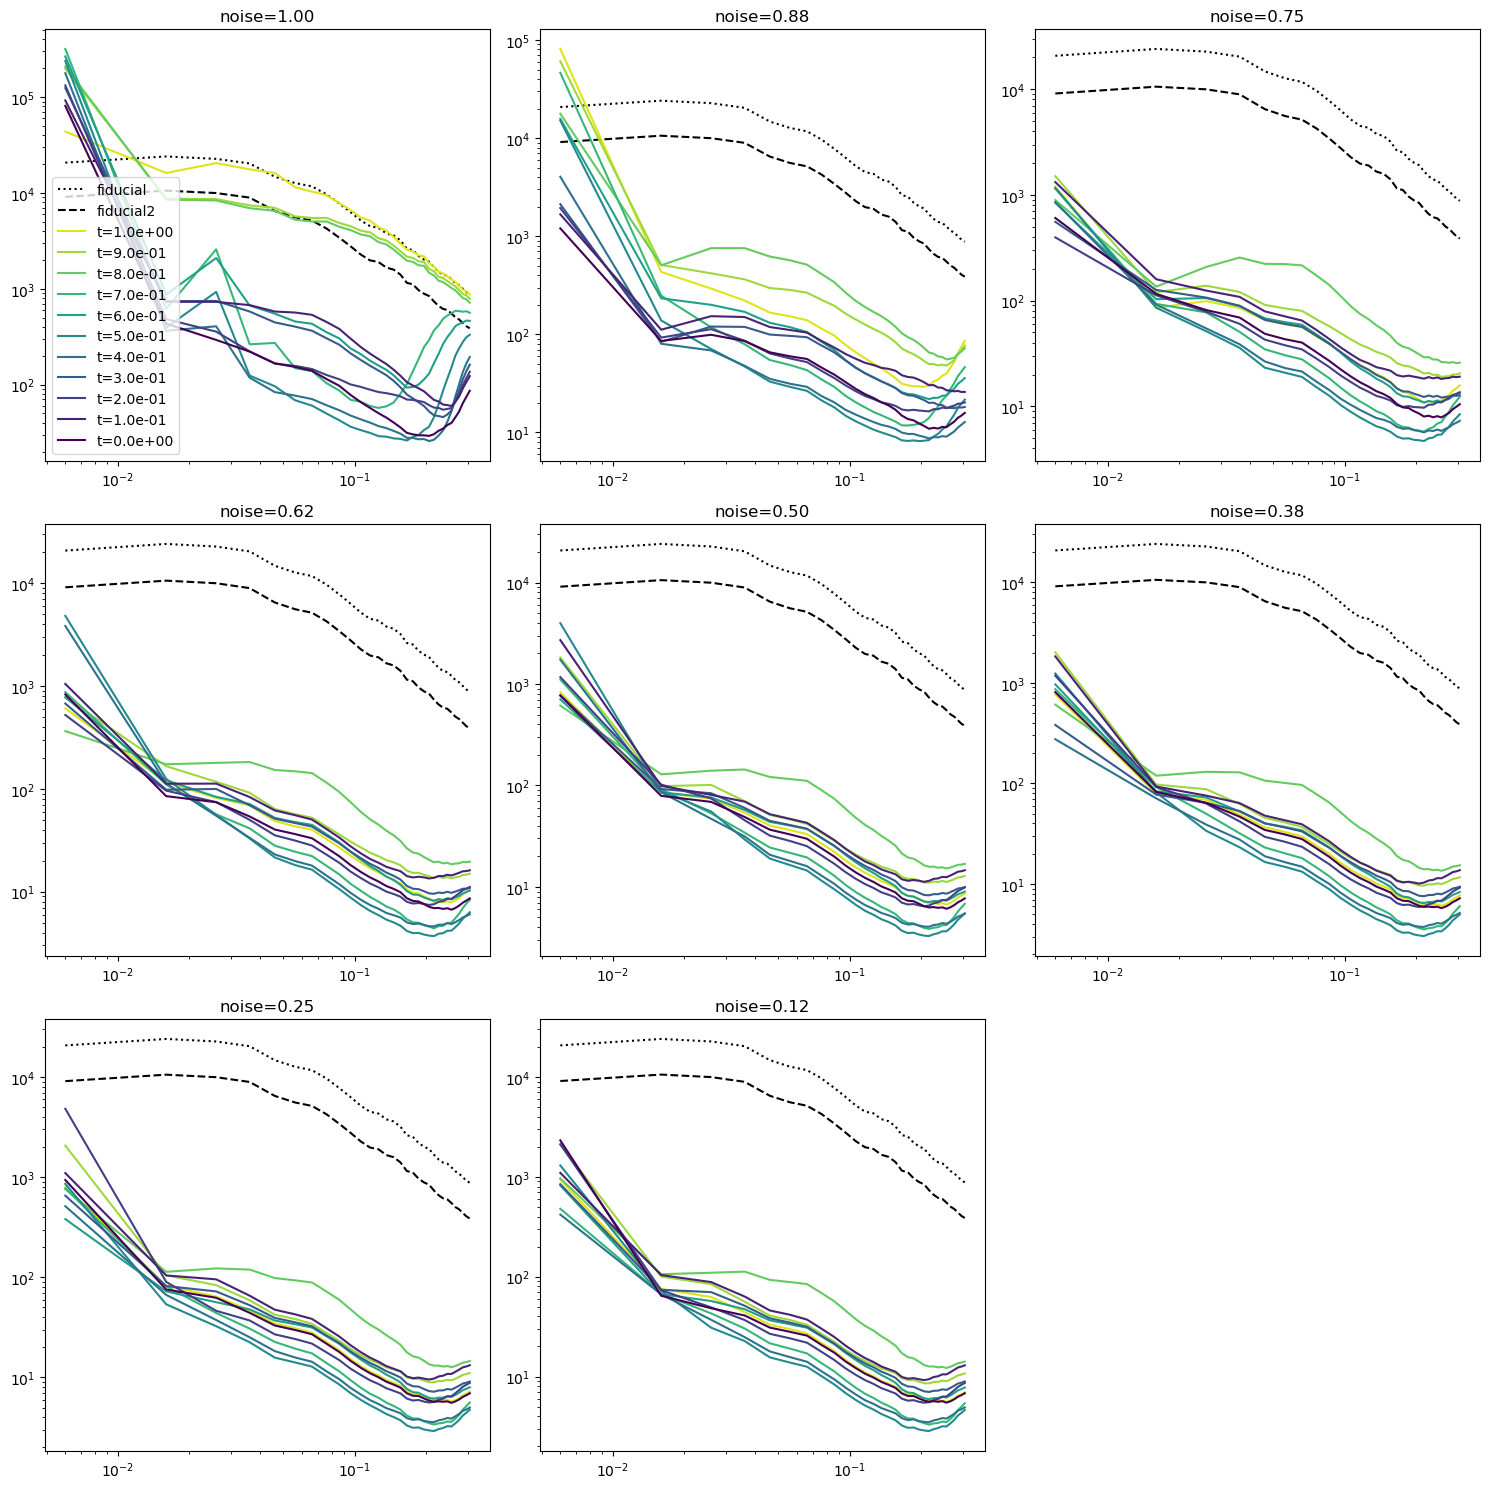

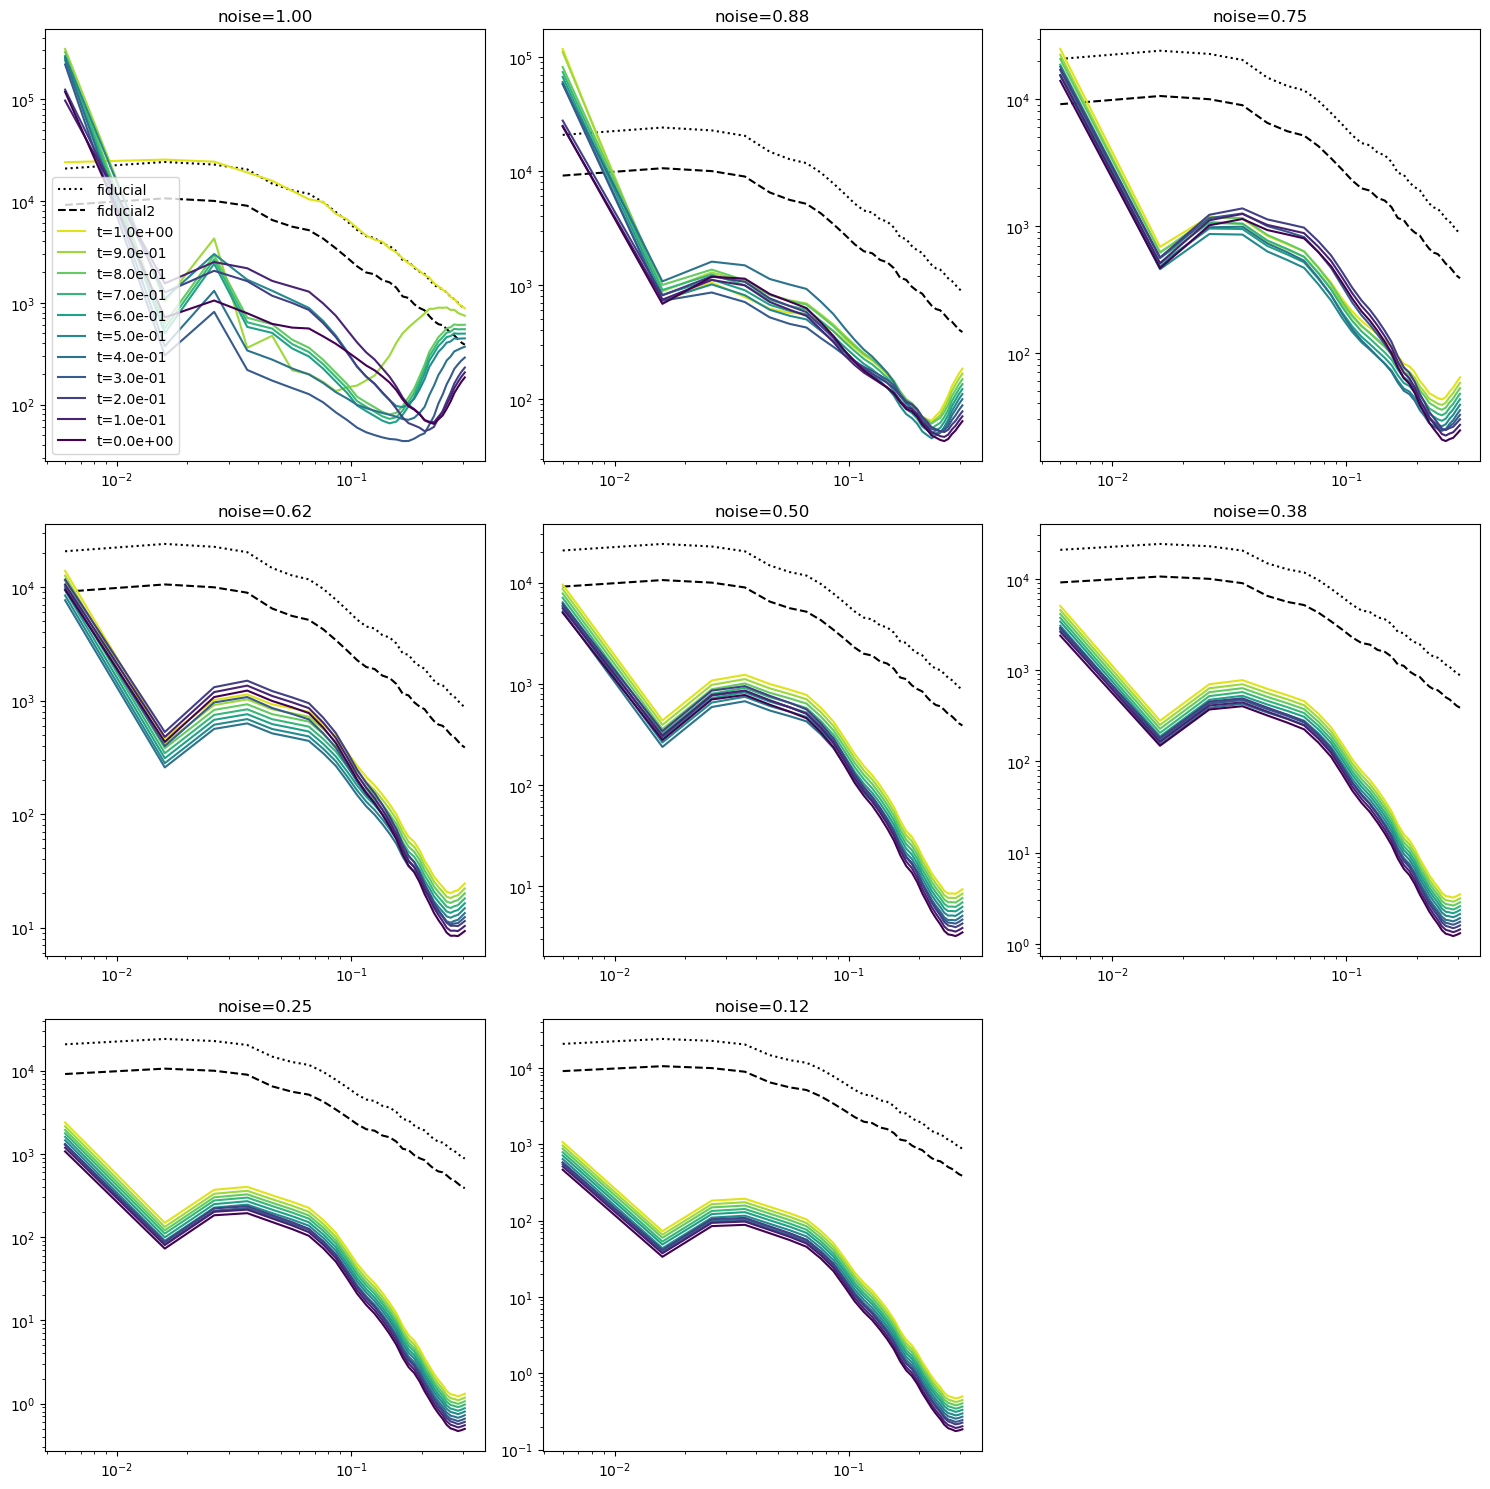

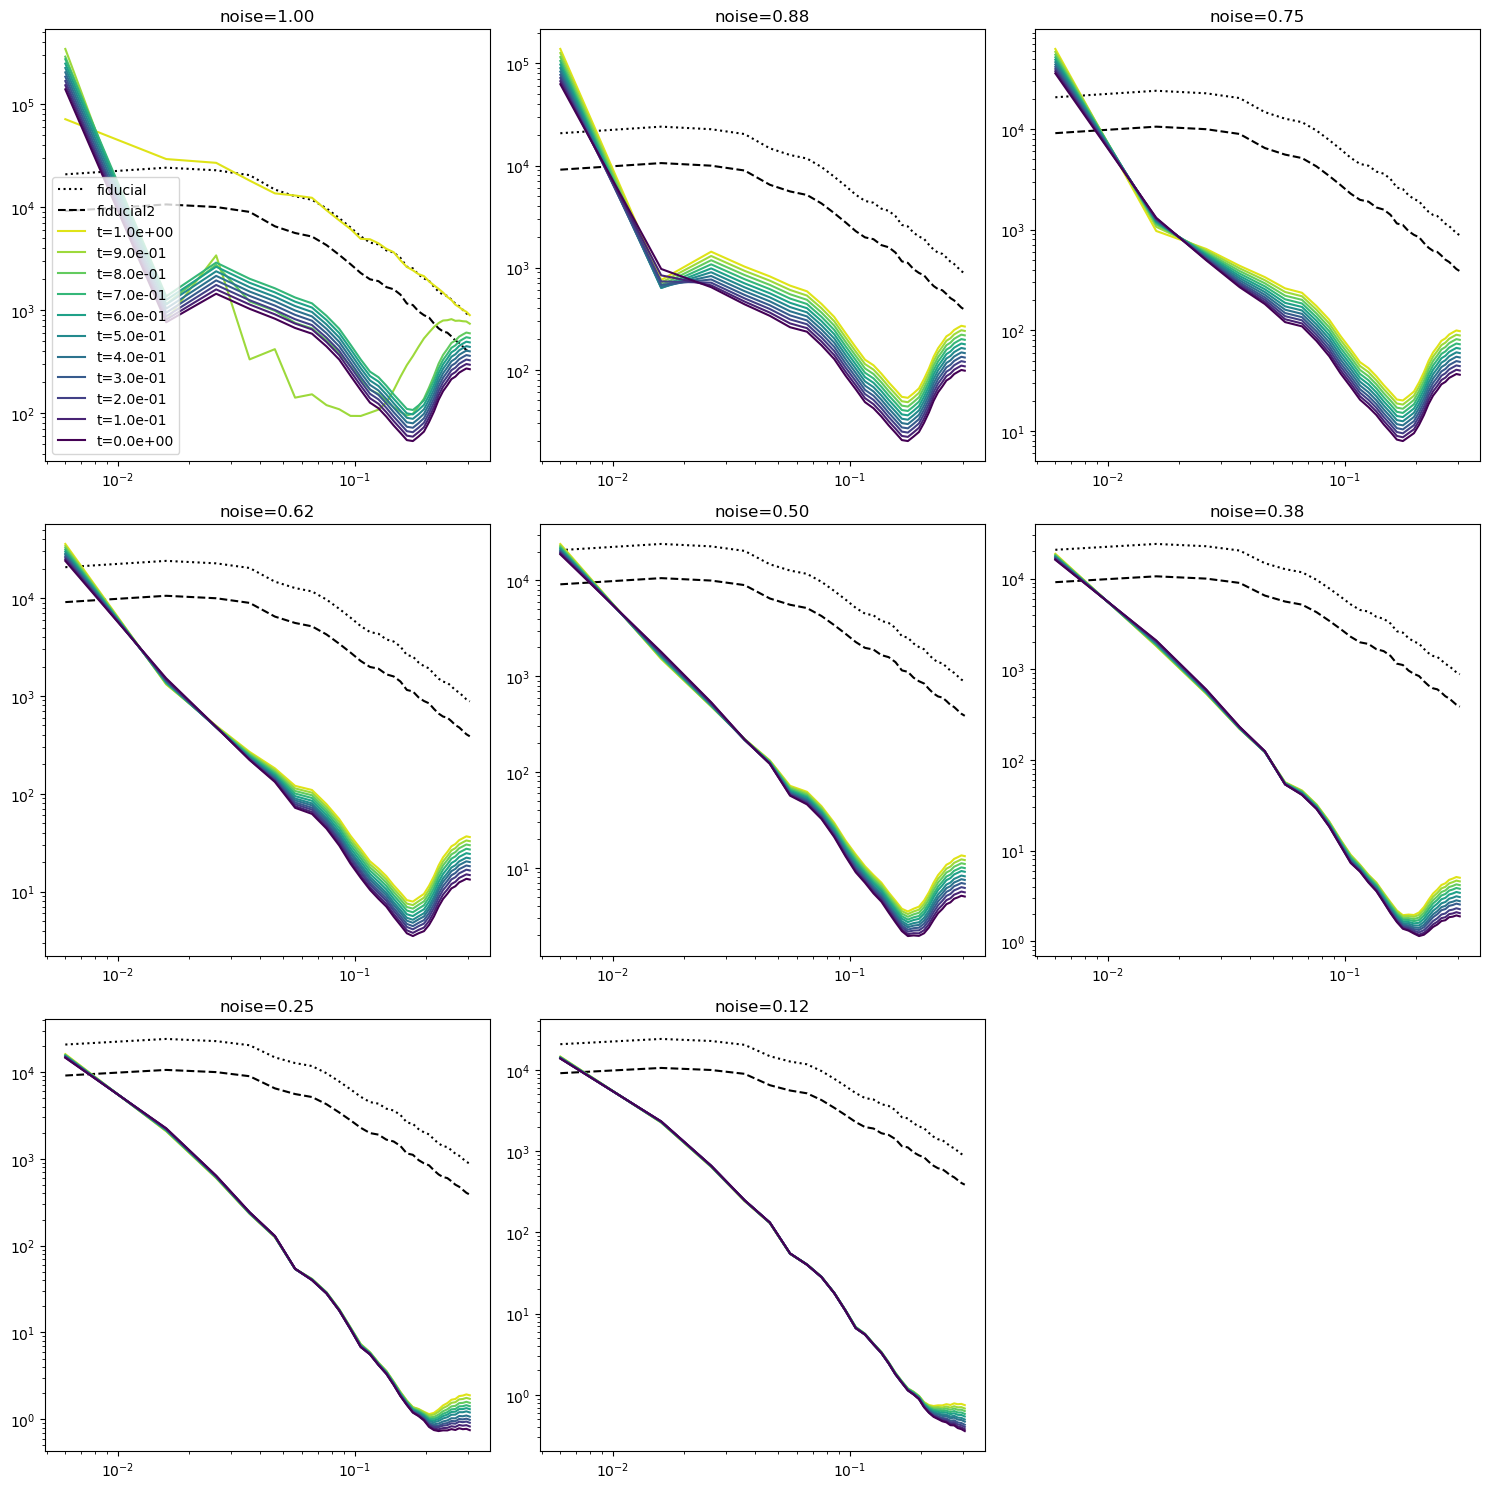

In [30]:
# plot_fn = lambda pk, *args, **kwargs: plt.plot(pk_init[0], pk_init[0]*pk, *args, **kwargs)
plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk_init[0], pk, *args, **kwargs)

for i_sample in range(n_samples):
    plt.figure(figsize=(15,15))
    for i_noise, noise in enumerate(noises[:-1]):
        plt.subplot(int(np.ceil(len(noises)/3)), 3, i_noise+1)
        colors = plt.get_cmap('viridis')(np.linspace(0,.95,len(ts)))[::-1]
        plt.gca().set_prop_cycle(color=colors)
        plot_fn(pk_init[1][0], 'k:', label="fiducial")
        plot_fn(pk_init2[1][0], 'k--', label="fiducial2")
        for i_time, time in enumerate(ts):
            plot_fn(pks2[i_noise, i_sample, i_time, 0, :], label=f"t={time:.1e}")
        if i_noise==0:plt.legend()
        plt.title(f"noise={noise:.2f}")
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), f"pk0_to_pk1_lin_{i_sample}.svg")
    plt.show()

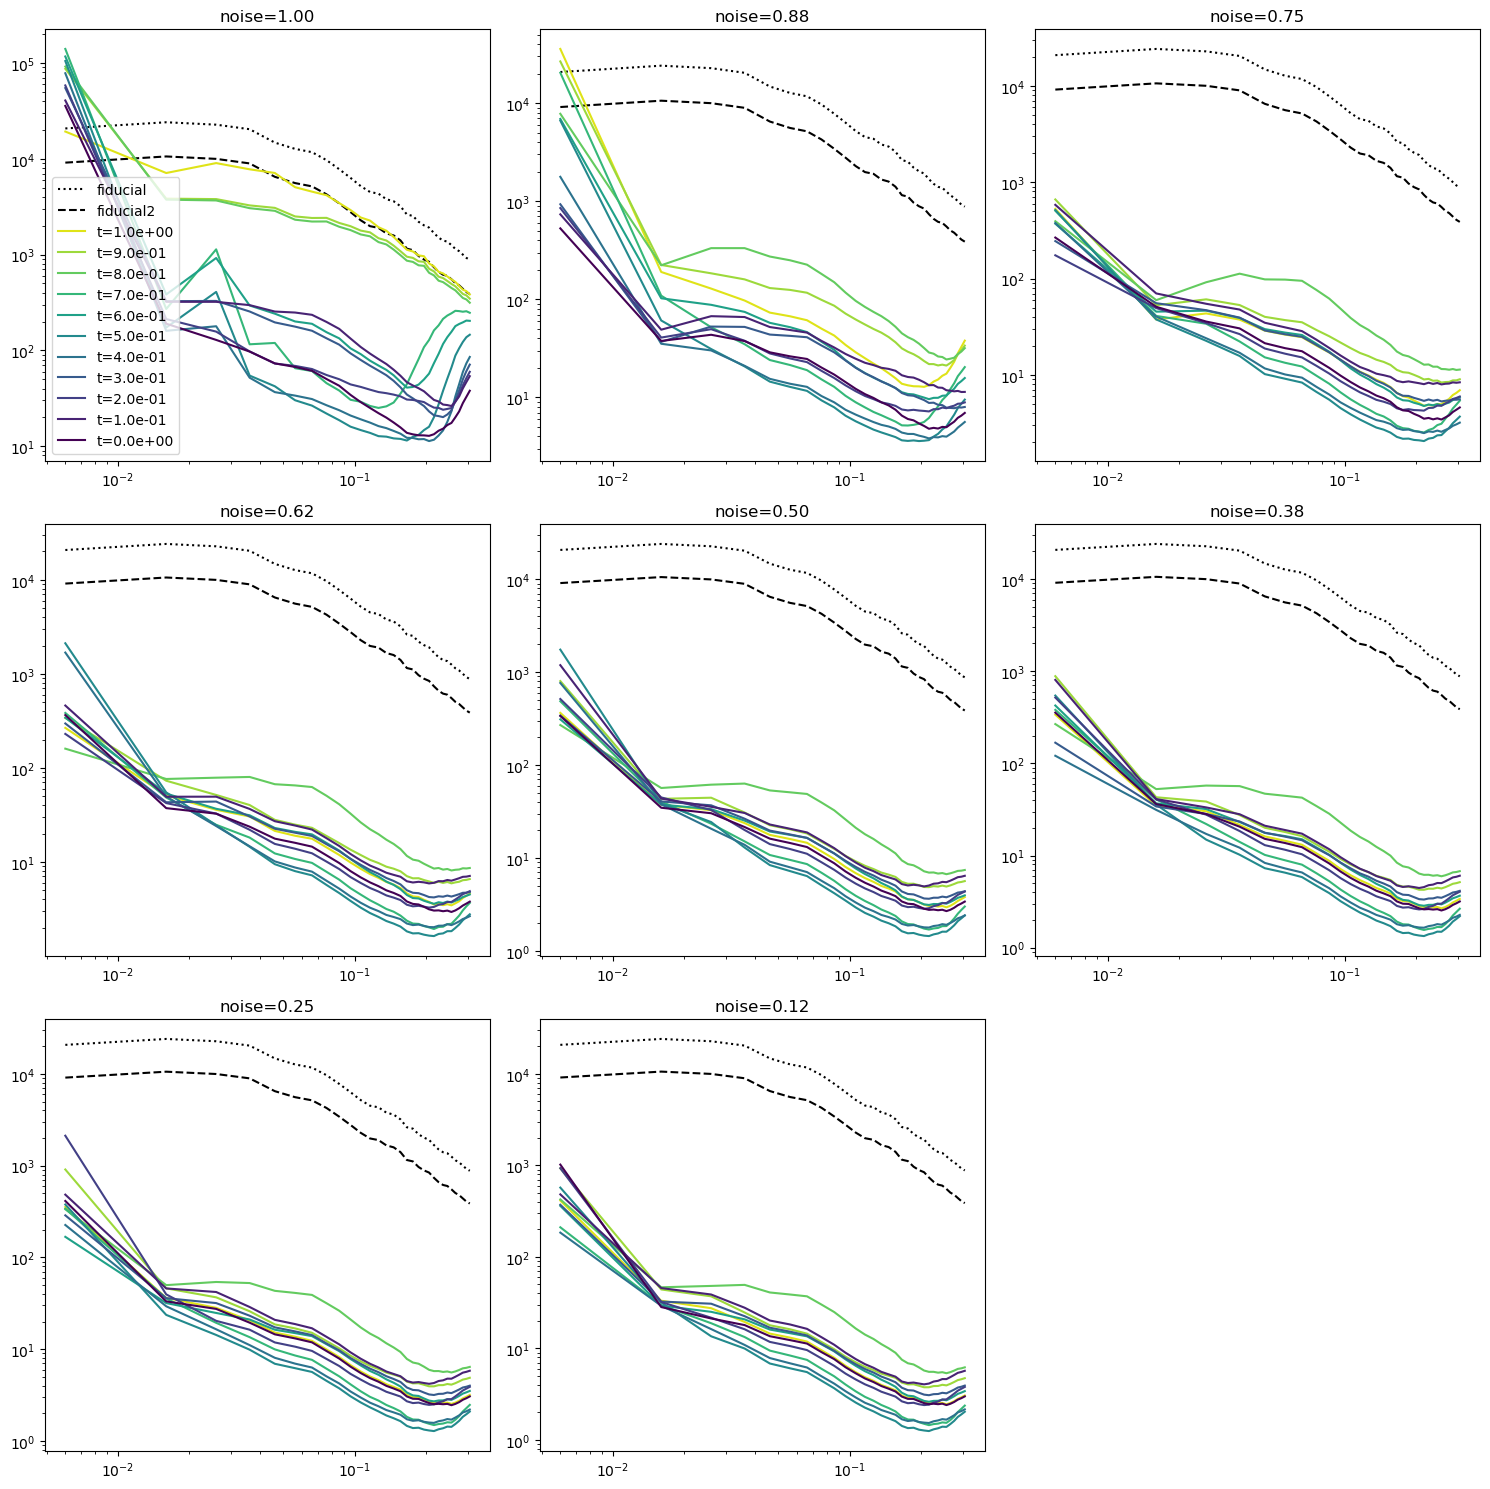

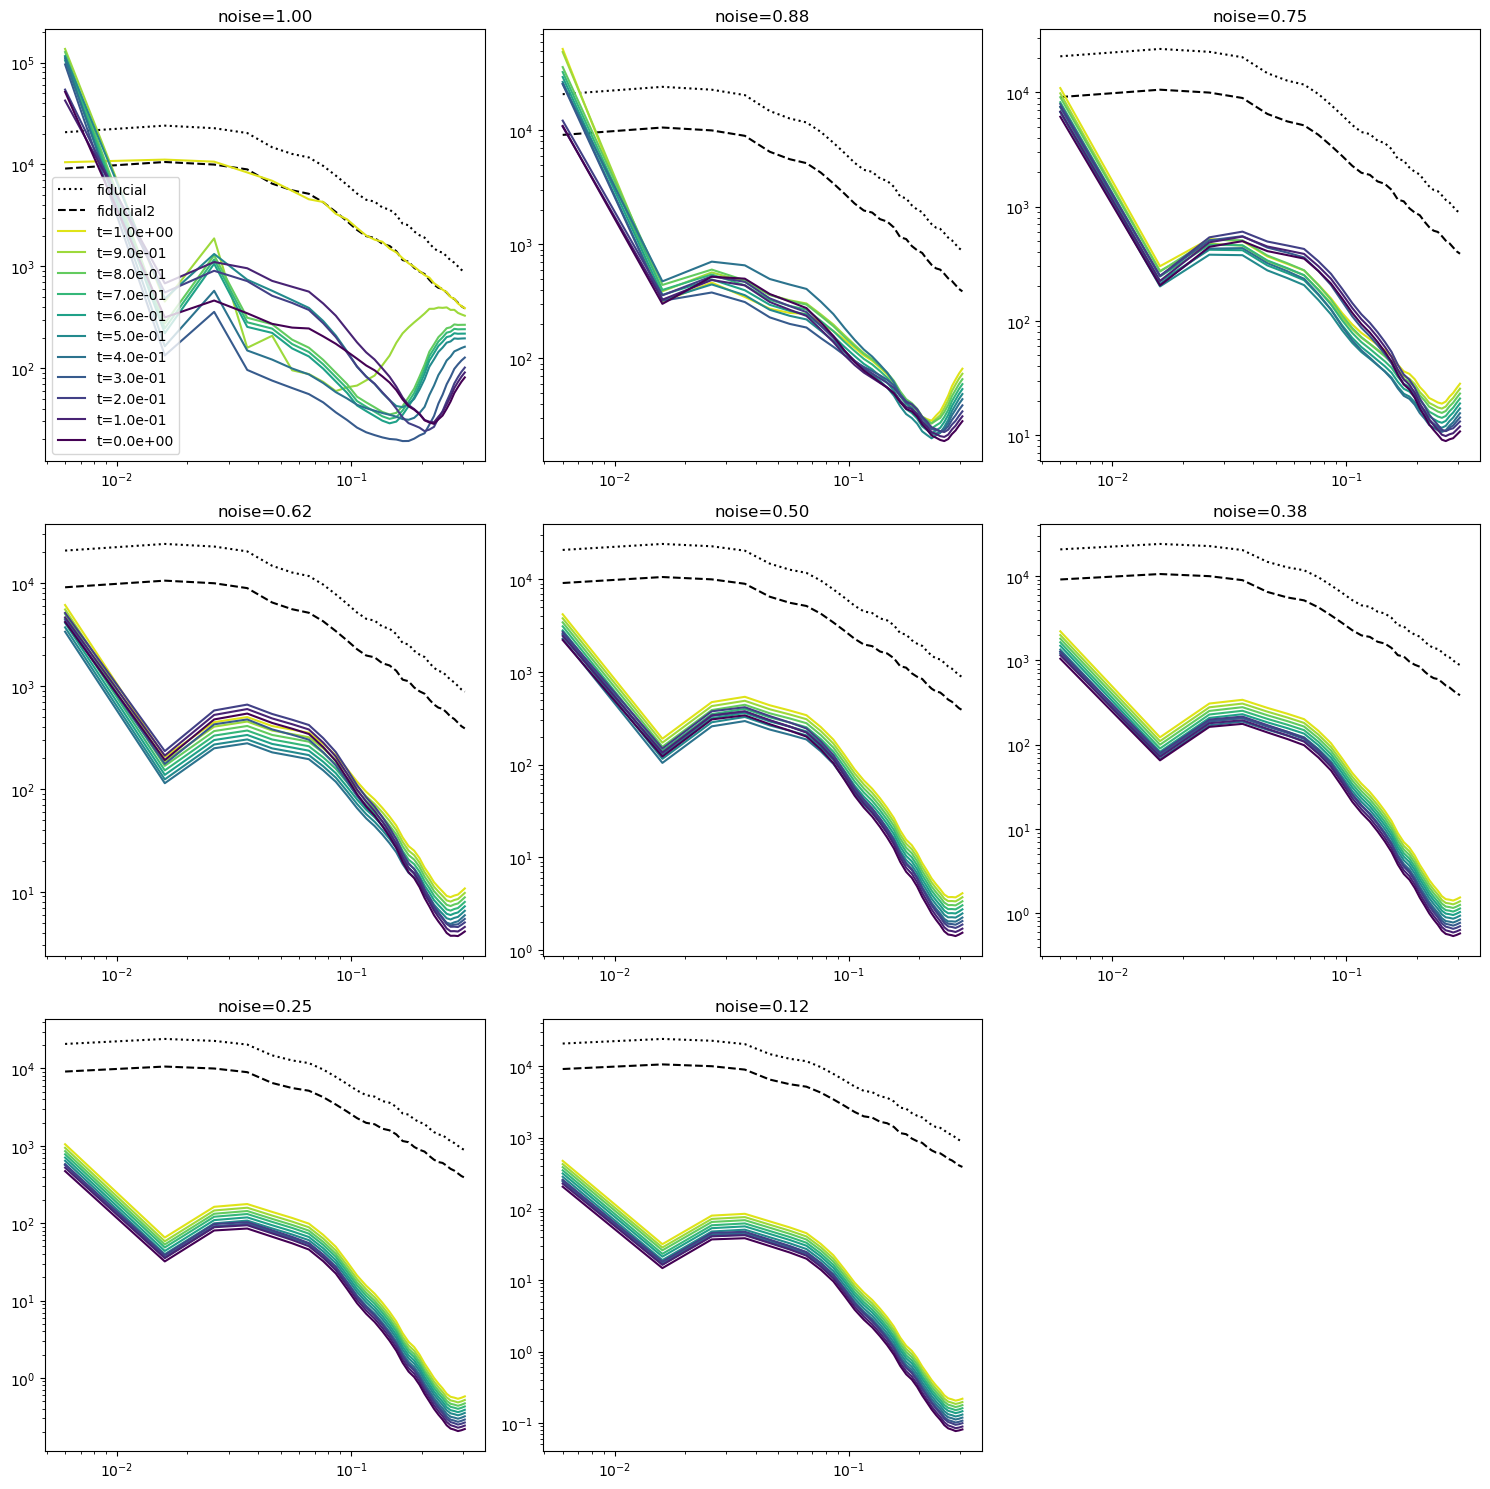

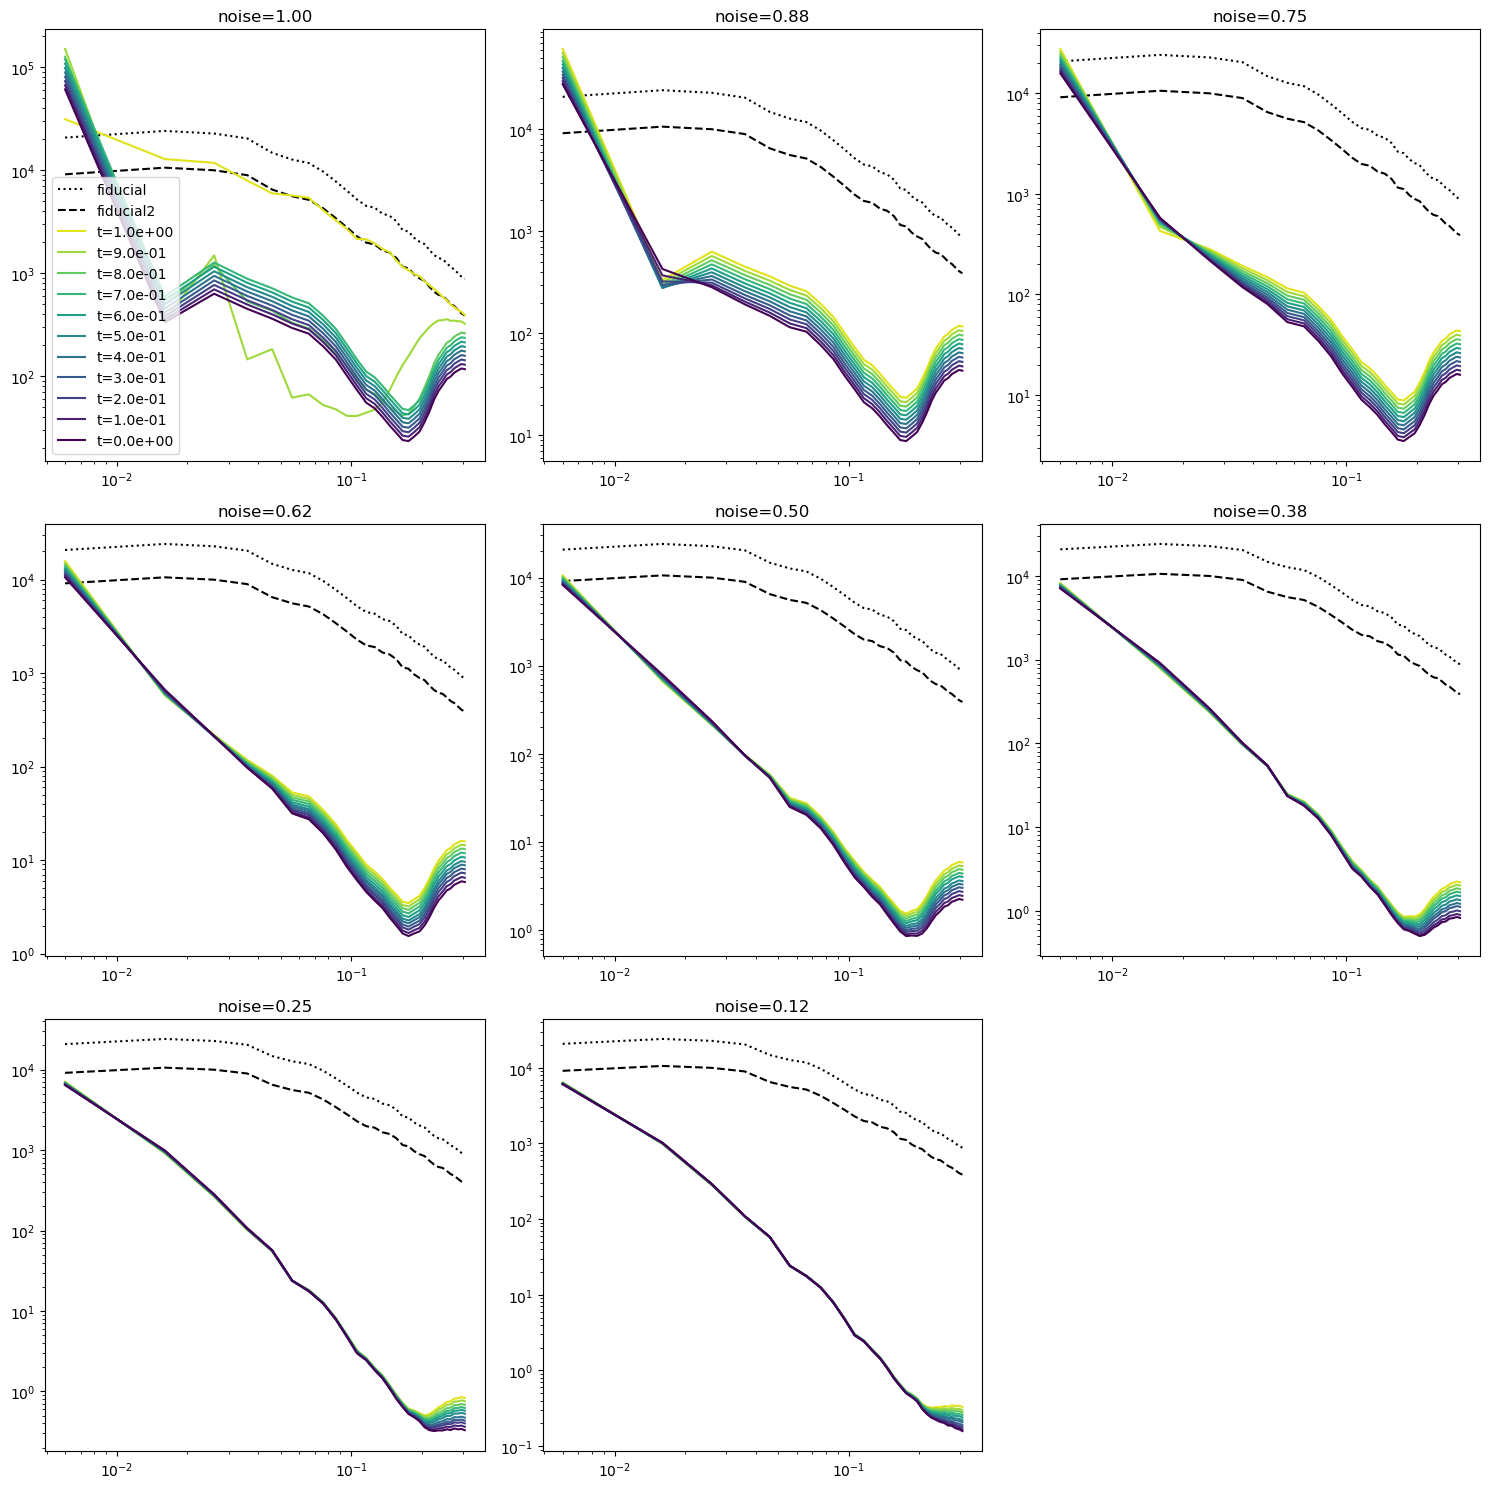

In [31]:
# plot_fn = lambda pk, *args, **kwargs: plt.plot(pk_init[0], pk_init[0]*pk, *args, **kwargs)
plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk_init[0], pk, *args, **kwargs)

for i_sample in range(n_samples):
    plt.figure(figsize=(15,15))
    for i_noise, noise in enumerate(noises[:-1]):
        plt.subplot(int(np.ceil(len(noises)/3)), 3, i_noise+1)
        colors = plt.get_cmap('viridis')(np.linspace(0,.95,len(ts)))[::-1]
        plt.gca().set_prop_cycle(color=colors)
        plot_fn(pk_init[1][0], 'k:', label="fiducial")
        plot_fn(pk_init2[1][0], 'k--', label="fiducial2")
        for i_time, time in enumerate(ts):
            plot_fn(pks3[i_noise, i_sample, i_time, 0, :], label=f"t={time:.1e}")
        if i_noise==0:plt.legend()
        plt.title(f"noise={noise:.2f}")
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), f"pk1_to_pk0_lin_{i_sample}.svg")
    plt.show()

## Samples analysis

In [ ]:
def plot_cosmo_contours(samples_list, samples_labels, samples_colors, cosmo_names, cosmo_labels, fiduc_cosmo_params):
    if samples_colors is None:
        samples_colors = [{'color':'b', 'alpha':0.3},{'color':'r'}]
    # Triangle plot
    samples_gds = []
    for samples in samples_list:
        samples_arr = np.array(list(samples.values())).T
        samples_gds.append(MCSamples(samples=samples_arr, names=cosmo_names, labels=cosmo_labels))
    gd = plots.get_subplot_plotter(subplot_size=None)
    # gd.settings.solid_colors='tab10_r'
    gd.triangle_plot(roots=samples_gds,
                    markers=fiduc_cosmo_params,
                    filled=True, 
                    legend_labels=samples_labels,
                    line_args=samples_colors,
                    contour_args=samples_colors,)

def plot_summary_table(samples, labels):
    # Plot summary table
    summary_dic = numpyro.diagnostics.summary(samples, group_by_chain=False) # NOTE: group_by_chain if several chains
    summary_arr = [list(list(summary_dic.values())[i].values()) for i in range(len(summary_dic.values()))]

    # Define a custom formatting function to vectorize on summary array
    def format_value(value):
        return f"{value:0.2f}"

    plt.subplot(position=[0,0,1,1]), plt.axis('off')
    # gd.fig.axes[-1]('tight'), plt.axis('tight'), plt.subplots_adjust(top=2), plt.gcf().patch.set_visible(False), 
    plt.table(cellText=np.vectorize(format_value)(summary_arr),
                # rowLabels=list(summary_dic.keys()),
                rowLabels=["$"+label+"$" for label in labels], 
                colLabels=list(list(summary_dic.values())[0].keys()),)